# Char RNN

In [1]:
import tensorflow as tf
import NLP_Utils as nlp
import time
import numpy as np

## Hyperparams

In [2]:
#Data
filename = 'tiny_shakespeare.txt'
'''
num_features: 1 => For dense representation
num_features: vocabulary size => For One-Hot representation
'''
num_features = 1 

#Cell
state_size = 200 #Default: 200 / Test: 4

#Batches & Vocab
batch_size = 64 #Default: 64 / Test: 5 or 1
seq_length = 50 #Default: 50 / Test: 3
overlap = 25 #Default 25 / Test: 3
vocab_strategy = 'all' 

#Test
test_size = 300 #Default: 300 / Test: 25

## Read Data & Manage Batches

In [3]:
batchManager = nlp.BatchManager()
batchManager.set_params(filename,batch_size,seq_length,overlap,vocab_strategy,mode='dense_rnn')
batchManager.get_params()

num_batches = batchManager._num_batches
vocab_size = batchManager._vocab_size

@params:
[filename : "tiny_shakespeare.txt"]
[text : "First Citi"]
[text_size : 1115394]
[vocab : ['p', 'a', 'B', 'e', 'i']]
[vocab_size : 65]
[mode : dense_rnn]
[batch_size : 64]
[seq_length : 50]
[overlap : 25]
[num_batches : 697]


In [4]:
batchManager.stats()

The corpus has 1115394 characters
Configuration:
[batch_size : 64]
[seq_length : 50]
[overlap : 25]

The current configuration gives us 697 batches of 64 observations each one looking 50 steps in the past and overlapping 25 steps


## Placeholders

seq placeholder has [None,None,num_features] dimensions because we want to use the same placeholder for train and for test.

So, for example:<br>
In train we may want: seq = [64,50,num_features]<br>
In test we may want: seq = [1,1,num_features]

That's why we have to set the dimensions as 'None'

In [5]:
seq = tf.placeholder(dtype=tf.float32,shape=[None,None,num_features],name='seq') #[Batch_size x seq_length x num_features]
seq_labels = tf.placeholder(dtype=tf.int32,shape=[None,None,num_features],name='seq_labels') #[Batch_size x seq_length]

temperature = tf.placeholder(tf.float32)

## Create RNN cell

In [6]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=state_size)

'''
batch_size : seq.get_shape()[0] instead of 'batch_size' 
in order to work with variable seq length, this is, for testing char by char
'''
zero_state = cell.zero_state(batch_size=tf.shape(seq)[0],dtype=tf.float32) 


in_state = tf.placeholder_with_default(input=zero_state,shape=[None,state_size])

In [7]:
output, out_state = tf.nn.dynamic_rnn(cell=cell,inputs=seq,initial_state=in_state)

In [8]:
output

<tf.Tensor 'rnn/transpose:0' shape=(?, ?, 200) dtype=float32>

## Create model

In [9]:
seq_labels_sparse = tf.reshape(seq_labels,shape=[tf.shape(seq_labels)[0],tf.shape(seq_labels)[1]])

In [10]:
logits = tf.contrib.layers.fully_connected(inputs=output,num_outputs=vocab_size,activation_fn=None)

loss = tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=seq_labels_sparse))

sample = tf.multinomial(logits=logits[:,-1],num_samples=1)[:,0]

In [11]:
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

## Train

In [12]:
num_epochs = 10

display_freq = num_batches//10

loss_list = list()
av_loss_list = list()

step = 0

last_epoch = -1

with tf.Session() as sess:
    start = time.time()
    tf.global_variables_initializer().run()
    
    for batchX,batchY,epoch in batchManager.generate_batches(num_epochs=num_epochs):

        
        if(last_epoch != epoch):
            print('Epoch %d:' % epoch)
            last_epoch = epoch
            
        
        _loss,_ = sess.run([loss,optimizer],{seq:batchX,seq_labels:batchY})
        
        loss_list.append(_loss)
        
        if(step % display_freq == 0):            
            if len(loss_list)>1: av_loss_list.append(np.average(a=loss_list[-display_freq]))
            
            print('At step %d:%d - Loss: %.2f - Elapsed time: %s' %(epoch,step,_loss,(time.time()-start)))
            
            ###TEST###
            sentence = 'A'
            state = None
            for _ in range(test_size):
                batch = np.array([batchManager.vocab_encode(sentence[-1])]) #Last character in sentence
                batch = batch.reshape(batch.shape[0],batch.shape[1],num_features)

                feed = {seq : batch}
                
                if state is not None: #First is none and must be None
                    feed.update({in_state:state})
                
                index,state = sess.run([sample,out_state],feed)
                sentence += batchManager.vocab_decode(index)
            print(sentence,'\n')
            ##########
            start = time.time()
            
        step += 1
            
            
        
print('Train finished')

Epoch 0:
At step 0:0 - Loss: 14615.50 - Elapsed time: 2.0693259239196777
At;O&hHt:?dF;3!kfYQnj LNWEnRS&;Q!YiEKFqqf;iFsbIfxf!!E?SWkkaGW c'ET&lctWL-ftq;ghX3NE?;p?r!Q$U&ofExS!r?&!bfr
$bt EtP3SSiL&DTdYSKCLx
DfLKSnwfRntiGoEel3;$DES&tATytZzfr!QYtfdz?rKe?q?akqET;I:Efko;Oaj!wh$Qc-tdfta!bLvflq&iENSEKr!AwX-$rhHmfiBcwnLNihStftS rH;fyEgKAHTihKti
ERi$ ;
hhr-SBah;E? GS nKEbw
tioiYtfDei 

At step 0:69 - Loss: 9769.21 - Elapsed time: 4.53809666633606
Ahuangsu rvwlc l Aett fa:nmo yh
 Snr 
msash
frns rn 

 tncl,U
eneo 
ybarrshele go I:ouhf?
enTsaos
ead,Aoei,we:hlm hTh  uoierdss o umlalfss
h elataerbLfapvy hohos
iAe mnlnmIrksyuCa,iceLq
o tum n
a  io 

t 
iles 
a 
fmobii.oo uit tyenin
S
am t Im
 a. dy 
enh Iaie m etenscan opl: otaFhsnaid o sWuSe sui  

At step 0:138 - Loss: 10529.23 - Elapsed time: 4.554114818572998
A-  m'r gatp y uTte  Ow,
ntatdeo
anIsn esF m feardr:,rted
eerlO bt,cis
er, ton 'at 
pn sGaothh t
e shmCIirtgetnfo :VesoUt tindsbhesPytte litkpt Atg no Ia goroddNee 
i vsfeidtn pae,gltnrnw  Se,

At step 2:1587 - Loss: 8752.16 - Elapsed time: 4.900505065917969
AominhyIa sIYmigl, brrmg mis lost:
Aetengdyeis yoeme buYso tagkfr

 bhourswohgeedero that ievii cir sopvq vhlENII:ENor tfot ohI thmGRDIN,EI:!dc
H  
o-m oA tyGhDTD II
Y
e,em
?my woyb yiu .s

eenssCh,u you uedab  ill ?were  hom mymamkHn of allid Grll ,fio temterttIT brsverr 
!s sfhou fhfIINII:
Pl EIDEI 

At step 2:1656 - Loss: 8263.44 - Elapsed time: 4.984599351882935
AICA s otr  no meaver ro,
e yfiees faohsog tane , will v
omyarr .w thes,lurdeay engeosg EhSUKEUGE:IYuwe sfie?tpte to ,hietn desgonletuarnh litFedthytoutTAd ancst asrasuher t
ec fare uo ravo-fyar'n,et the saerthth tes o thbh hre scAeptd
y h
iik rs knK ghea t hoy,f .t  yo ?aytrny n  ostinn, tant I  tes 

At step 2:1725 - Loss: 8221.28 - Elapsed time: 4.915520906448364
Aerl; mW you itc?wove oner; tpir
mH teme tk wale  is aveas to any ma me gCl'EEC:AM
O:IAytH!tt bhougTh?iuor otm dlypli ok si  wytiam, nl voe!e  dou
 bo wrres
atd haydare'e
gsytiadt theswome oou thi 

At step 4:3174 - Loss: 7705.58 - Elapsed time: 4.555116653442383
Ah
NwNCNIN:
Wagkw
hAordhinh tx!pmeng,uOT lurd,'Mcisanern; ordelore te,hYh
aA!,OMW
NhKKl DLITLL
W
ARX nell baec'e towber, Iesdmenher Iyteer ittohMom.fell,mDayk the  oiges yhohi our ;hetex, 

LoYd 

:Hskeo recedthire lo:
 have oedsolnNo Corsa troe 
No t
uugNteed
 etkn noethW farurs ill 
Lnd for wiar ta 

At step 4:3243 - Loss: 8017.58 - Elapsed time: 4.437984943389893
Aescell nrakn'n is dan ell morl,'i, mytoen ofer  ouly doesthelt.to thet 'ovt sfu
sd
avk oo- nricy ling uo Mouf thy wellom mill miad;3enchhlirs!
Do  tot'heng oe inginy
ii, tetOot andtheycomtrcLo:  natdyhosth
t the sees
And Ihat it showess
ohac  erchx arciushTop ssuenh your of yoo wonin,
 hy
can Eaptee 

At step 4:3312 - Loss: 7489.44 - Elapsed time: 4.464013338088989
Aanes mall wrll a eformard iu'hyrn wy uniwousfrtd o  wenher, mes fienhHsbwlere,-

er paot:
.hy fagher t
eswnis k yytrmen?'ighwlea ? trengtger,we 
avhfnd deeno
And for,
 have  iu, wrninso sof the ho

At step 6:4761 - Loss: 7275.61 - Elapsed time: 4.565128326416016
Arshidcy  o n  shompr
c mis?gedthis, h dbo-thWis smese wonrtg iswer ote feotshI?mishyoe h
KUKE VENPINT
NS T
So tevingIen.wordned the p willo
That'Cell
Dno not  ords uu
dof he provestth with trgrm
:ofsI
 hDoAA:
V: what we.,ffLet yadyamayett corouny how Ien millay frat sectos

an.IhDarepains

SUKE IDT
 

At step 6:4830 - Loss: 7582.38 - Elapsed time: 4.591156721115112
A  wA nhow?
e  opsanoe int ,,
at the cartseB W thes tges do knos Aam an  h inhKece.m
e devgir,p?slf 

:
Rmen andwhie stand

KUCETIS:
No cypllprnhwRlnSo ao t lordid, kno es my fiutross beent'b
 .try lain 
Afarls
To towe qwe,nhoo s
en aer iyghB Tur osrsthSs cay 

LRORG:
Mou frll Iou
oold to oub.herr:
W 

Epoch 7:
At step 7:4899 - Loss: 7669.60 - Elapsed time: 6.25702977180481
Asnaer
ISEMAUoIA: IhLUDINIIIALIACLIUA:
I:nInrosdteen somoenhFlcean;so
oodyeer, lew folties,samolds
aer g
e; time bne  bhe Aendte,st yLed  ofer to bhe cito dyou cy wind ad atger.wrom fatsts 

At step 9:6348 - Loss: 7231.37 - Elapsed time: 4.423969507217407
A,
Cmiisiniene y
ave in the o rf
So a,  ouct bhe est opy
i ,n h  ell  
ave i  hen bu
e of donry?in terng me she tot men
rm 
aghervaaso
Cr holdisrstluwer  

SOFOCMIS:
Lnko erg dourse is francen.his pclivert his ce ore teplur
,me; bhemedsed gTmu
And pighh aarteb,rn
ieviowers

SUEN
IOLARICs
What momenst 

At step 9:6417 - Loss: 7100.11 - Elapsed time: 4.432979345321655
Ae pritces 

GEMT
ST
Sivk
What waust bpoe sypo polty whinc frll buin thou of wife me 
ear in have thire sarkslal Lorrs
The swe are the giave nhi 
er.is sie in worlsb.hYou for no knen it shall the ge recell; for maren h
GUTORKE:
:
at camc rettCAersatdes

FODUEESTUS:
TK hade 
Sll vitdt
CidhNhe witken a 

At step 9:6486 - Loss: 7212.75 - Elapsed time: 4.43898606300354
A,
B e pimy;ge tatptn sucegda day tant;ll bhSoui foi hishNhorsm
aroacdworther whisdswerth
 t
ose goodin mis bi wiet than not thou ara the pohCancs inger? ay and ill but saeefs morcers of vryelvi
g u

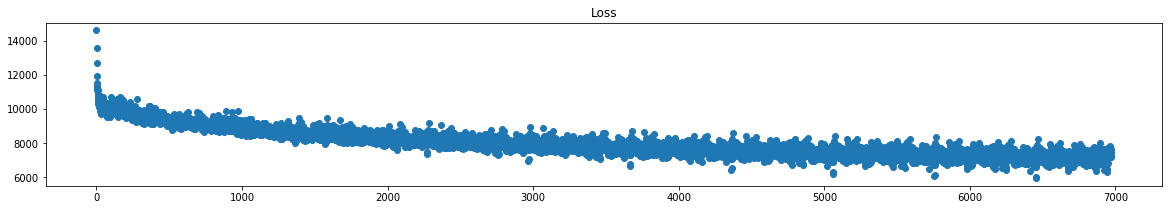

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,3))
plt.title('Loss')
plt.scatter(x=range(len(loss_list)),y=loss_list)
plt.show()

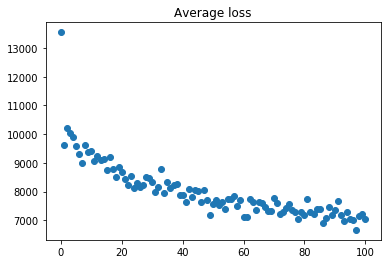

In [15]:
plt.title('Average loss')
plt.scatter(x=range(len(av_loss_list)),y=av_loss_list)
plt.show()